## import thư viện

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import MinMaxScaler

from scipy import stats

In [22]:
sns.set_style("whitegrid")

## data reading

In [23]:
#df = pd.read_csv('/content/drive/MyDrive/Project_3/DS111/Data/final_data.csv')
df = pd.read_csv('/content/drive/MyDrive/DS111/Do an/final_data.csv')

df.head()

,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Location,Origin,Associated Types,OFDA Response,Appeal,AID Contribution ('000 US$),...,Total Affected,Total Damage ('000 US$),"Total Damage, Adjusted ('000 US$)",CPI,Admin Units,Entry Date,Last Update,economic_region,Start Date,End Date
0,Natural,Meteorological,Storm,Tropical cyclone,Southern coast,Unknow,No,No,No,NaN,...,0.0,0.0,0.0,9.156133,NaN,2006-09-17,2023-09-25,['Ngoại lệ'],1953-09-26,1953-09-26
1,Natural,Meteorological,Storm,Tropical cyclone,NaN,Unknow,No,No,No,NaN,...,0.0,0.0,0.0,9.288532,NaN,2003-07-01,2023-09-25,['Ngoại lệ'],NaN,NaN
2,Natural,Biological,Epidemic,Bacterial disease,"Saigon, Mekong delta",Unknow,No,Yes,No,NaN,...,10848.0,0.0,0.0,10.598376,NaN,2003-07-01,2023-09-25,"['Vùng Đông Nam Bộ', 'Vùng đồng bằng sông Cửu ...",1964-01-01,1964-01-01
3,Natural,Meteorological,Storm,Tropical cyclone,China sea coast,Unknow,No,Yes,No,NaN,...,700000.0,50000.0,471770.0,10.598376,NaN,2006-09-17,2023-09-25,['Ngoại lệ'],NaN,NaN
4,Natural,Hydrological,Flood,Flood (General),NaN,Unknow,No,No,No,NaN,...,0.0,0.0,0.0,10.598376,NaN,2003-07-01,2023-09-25,['Ngoại lệ'],NaN,NaN


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335 entries, 0 to 334
Data columns (total 33 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Disaster Group                     335 non-null    object 
 1   Disaster Subgroup                  335 non-null    object 
 2   Disaster Type                      335 non-null    object 
 3   Disaster Subtype                   335 non-null    object 
 4   Location                           317 non-null    object 
 5   Origin                             335 non-null    object 
 6   Associated Types                   335 non-null    object 
 7   OFDA Response                      335 non-null    object 
 8   Appeal                             335 non-null    object 
 9   AID Contribution ('000 US$)        20 non-null     float64
 10  Magnitude                          90 non-null     float64
 11  Magnitude Scale                    268 non-null    object 

# 1. Sự gia tăng lạm phát, mất sức mua của đồng tiền

Biểu đồ đường thể hiện xu hướng thay đổi của chỉ số lạm phát và sức mua của đồng tiền (1953 - 2024)

In [25]:
df_plot = df[['Start Year', 'CPI']].dropna().sort_values('Start Year')

# Chuẩn hóa CPI (base year = 1)
df_plot['CPI_index'] = df_plot['CPI'] / df_plot['CPI'].iloc[0]

# Sức mua tương đối (inverse CPI)
df_plot['Purchasing_Power_Index'] = 1 / df_plot['CPI_index']

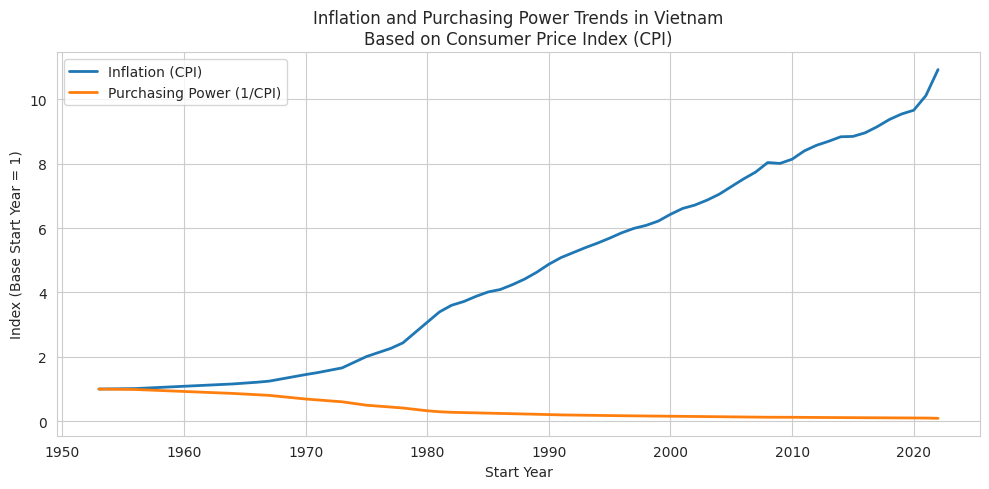

In [26]:
plt.figure(figsize=(10, 5))

plt.plot(
    df_plot['Start Year'],
    df_plot['CPI_index'],
    label='Inflation (CPI)',
    linewidth=2
)

plt.plot(
    df_plot['Start Year'],
    df_plot['Purchasing_Power_Index'],
    label='Purchasing Power (1/CPI)',
    linewidth=2
)

plt.xlabel('Start Year')
plt.ylabel('Index (Base Start Year = 1)')
plt.title(
    'Inflation and Purchasing Power Trends in Vietnam\n'
    'Based on Consumer Price Index (CPI)'
)

plt.legend()
plt.tight_layout()
plt.show()

*   Sự bùng nổ của CPI: Chỉ số giá tiêu dùng (CPI) của Việt Nam có sự gia tăng rất mạnh, đặc biệt là từ sau những năm 1980 (giai đoạn Đổi Mới). Đường biểu diễn lạm phát dốc đứng dần theo thời gian.

*   Sự sụt giảm giá trị đồng tiền: Đường "Purchasing Power" (Sức mua) cho thấy 1 đồng ở năm 1953 có giá trị cao hơn gấp nhiều lần so với hiện tại. Đến sau năm 2010, đường này gần như tiệm cận sát trục hoành, cho thấy tốc độ trượt giá của tiền tệ là cực kỳ lớn trong suốt 70 năm qua.

# 2. Sự gia tăng của chỉ số CPI cho thấy những thảm họa trong quá khứ có thiệt hại rất lớn nếu tính theo tỷ giá, sức mua tại thời điểm hiện tại (2024)

Biểu đồ thể hiện sự thay đổi của chỉ số lạm phát (CPI) so với hệ số điều chỉnh

In [27]:
df_adj = df[
    ['Start Year',
     "Total Damage ('000 US$)",
     "Total Damage, Adjusted ('000 US$)",
     'CPI']
].dropna()

df_adj['Adjustment_Factor'] = (
    df_adj["Total Damage, Adjusted ('000 US$)"] /
    df_adj["Total Damage ('000 US$)"]
)

In [28]:
df_adj

,Start Year,Total Damage ('000 US$),"Total Damage, Adjusted ('000 US$)",CPI,Adjustment_Factor
0,1953,0.0,0.0,9.156133,NaN
1,1956,0.0,0.0,9.288532,NaN
2,1964,0.0,0.0,10.598376,NaN
3,1964,50000.0,471770.0,10.598376,9.4354
4,1964,0.0,0.0,10.598376,NaN
...,...,...,...,...,...
326,2022,0.0,0.0,100.000000,NaN
327,2022,0.0,0.0,100.000000,NaN
328,2022,0.0,0.0,100.000000,NaN
329,2022,65000.0,65000.0,100.000000,1.0000


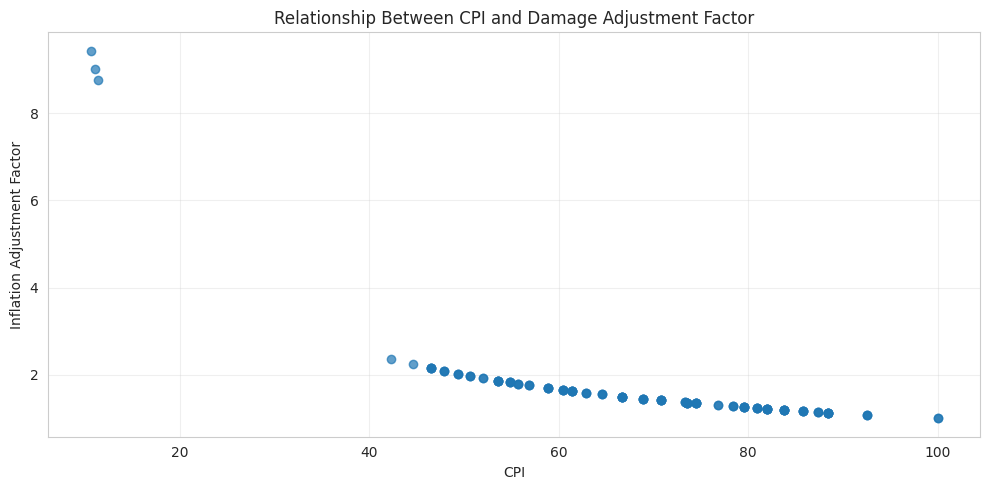

In [29]:
plt.figure(figsize=(10, 5))

plt.scatter(
    df_adj['CPI'],
    df_adj['Adjustment_Factor'],
    alpha=0.7
)

plt.xlabel('CPI')
plt.ylabel('Inflation Adjustment Factor')
plt.title('Relationship Between CPI and Damage Adjustment Factor')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


**Biểu đồ phân tán này giải thích cơ chế dùng để "quy đổi" tiền quá khứ về giá trị hiện tại.**

*   Tương quan nghịch mãnh liệt: Khi CPI thấp (những năm xa xưa), hệ số điều chỉnh (Adjustment Factor) cực kỳ cao (lên đến gần 10 lần trong biểu đồ). Điều này phản ánh rằng một khoản thiệt hại nhỏ trong quá khứ thực chất mang giá trị kinh tế rất lớn nếu tính theo tỷ giá và sức mua hiện nay.

* Độ dốc của sự thay đổi: Có một khoảng trống dữ liệu lớn giữa CPI ~15 và CPI ~40, nhưng xu hướng chung là phi tuyến tính (non-linear). Khi CPI tiến gần đến 100 (thời điểm hiện tại), hệ số điều chỉnh tiến về 1, nghĩa là giá trị danh nghĩa và giá trị điều chỉnh trùng nhau.

# 3. So sánh thiệt hại danh nghĩa và thiệt hại đã điều chỉnh (t-test)

## Biểu đồ

In [30]:
df_year = df[
    ['Start Year',
     "Total Damage ('000 US$)",
     "Total Damage, Adjusted ('000 US$)"]
].dropna()

df_year = df_year.groupby('Start Year').sum().reset_index()

In [31]:
df_year

,Start Year,Total Damage ('000 US$),"Total Damage, Adjusted ('000 US$)"
0,1953,0.0,0.0
1,1956,0.0,0.0
2,1964,50000.0,471770.0
3,1966,10000.0,90163.0
4,1967,500.0,4387.0
5,1970,0.0,0.0
6,1971,0.0,0.0
7,1973,0.0,0.0
8,1975,0.0,0.0
9,1977,0.0,0.0


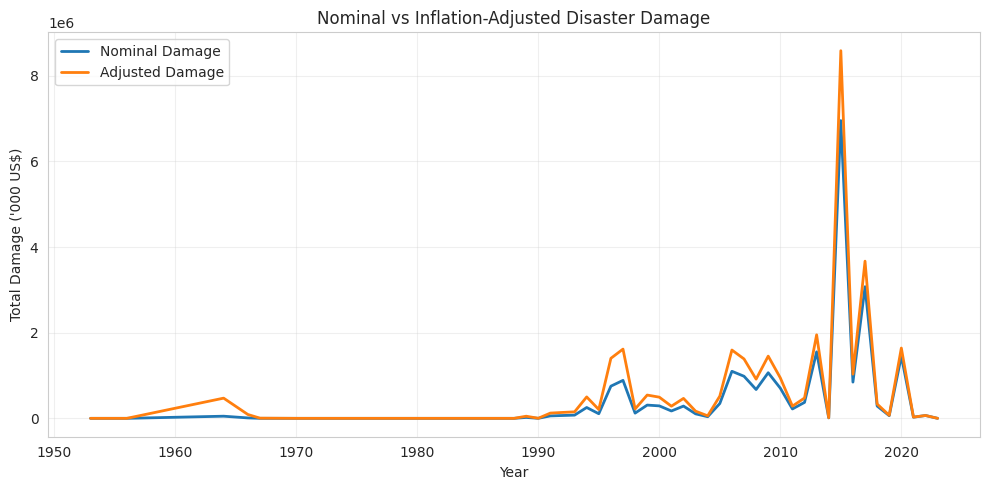

In [32]:
plt.figure(figsize=(10, 5))

plt.plot(
    df_year['Start Year'],
    df_year["Total Damage ('000 US$)"],
    label='Nominal Damage',
    linewidth=2
)

plt.plot(
    df_year['Start Year'],
    df_year["Total Damage, Adjusted ('000 US$)"],
    label='Adjusted Damage',
    linewidth=2
)

plt.xlabel('Year')
plt.ylabel("Total Damage ('000 US$)")
plt.title('Nominal vs Inflation-Adjusted Disaster Damage')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## Kiểm định paired t-test

**Mục tiêu:** Kiểm tra việc điều chỉnh theo CPI có làm thay đổi đáng kể giá trị thiệt hại hay không.


**Giả thuyết (H0):** Trung bình thiệt hại danh nghĩa và trung bình thiệt hại đã điều chỉnh theo CPI ***không có sự khác biệt.***

**Đối thuyết (H1):** Trung bình thiệt hại danh nghĩa và trung bình thiệt hại đã điều chỉnh theo CPI ***có sự khác biệt.***

In [33]:
df_damage = df[["Total Damage ('000 US$)", "Total Damage, Adjusted ('000 US$)"]].copy()

In [34]:
t_stat, p_value = stats.ttest_rel(
    df_damage["Total Damage ('000 US$)"],
    df_damage["Total Damage, Adjusted ('000 US$)"]
)

print('t-Value', t_stat)
print(f'p-Value {p_value:.10f}')

t-Value -4.511637261946166
p-Value 0.0000089222


**p-value < mức ý nghĩa (0.05) -> Bác bỏ giả thuyết H0** - Có sự khác biệt rất có ý nghĩa thống kê giữa Total Damage (danh nghĩa) và Total Damage, Adjusted (đã điều chỉnh).

*   Lạm phát làm sai lệch nghiêm trọng giá trị thiệt hại nếu chỉ dùng số danh nghĩa. Thiệt hại đã điều chỉnh phản ánh đúng sức mua và giá trị thực hơn. t-value âm cho thấy trung bình Adjusted Damage > Nominal Damage, đặc biệt rõ ở các năm CPI thấp (quá khứ). Điều này khẳng định rằng việc không điều chỉnh theo lạm phát sẽ dẫn đến đánh giá sai mức độ thiệt hại kinh tế của các sự kiện thiên tai, đặc biệt trong các giai đoạn lịch sử có mức CPI thấp.

## Kiểm định thống kê thiệt hại đã điều chỉnh có khác nhau giữa các mức CPI không? (ANOVA)

**Mục tiêu:** Kiểm tra sau khi điều chỉnh theo CPI, giá trị thiệt hại còn phụ thuộc vào mức CPI hay không.

**Giả thuyết (H0):** Trung bình thiệt hại đã điều chỉnh theo CPI là ***như nhau*** giữa các nhóm CPI.

**Đối thuyết (H1):** Có ***ít nhất một nhóm CPI*** có trung bình thiệt hại đã điều chỉnh ***khác*** các nhóm còn lại.

In [35]:
df_cpi = df[['CPI', "Total Damage, Adjusted ('000 US$)"]].dropna()

# chia dữ liệu thành 3 nhóm
df_cpi['CPI_Group'] = pd.qcut(
    df_cpi['CPI'],
    q=3,
    labels=['Low CPI', 'Medium CPI', 'High CPI']
)

In [36]:
group_low = df_cpi[df_cpi['CPI_Group'] == 'Low CPI']["Total Damage, Adjusted ('000 US$)"]
group_mid = df_cpi[df_cpi['CPI_Group'] == 'Medium CPI']["Total Damage, Adjusted ('000 US$)"]
group_high = df_cpi[df_cpi['CPI_Group'] == 'High CPI']["Total Damage, Adjusted ('000 US$)"]

f_stat, p_value = stats.f_oneway(group_low, group_mid, group_high)

print('F-Value', f_stat)
print('p-Value', p_value)

F-Value 1.9801139495727618
p-Value 0.13970035228828442


**p-value > mức ý nghĩa (0.05) -> Không bác bỏ giả thuyết H0** - Không có sự khác biệt có ý nghĩa thống kê về "Total Damage Adjusted" giữa các nhóm CPI thấp – trung bình – cao.
*   Việc điều chỉnh thiệt hại theo CPI đã loại bỏ phần lớn ảnh hưởng của lạm phát, khiến giá trị thiệt hại thực tế trở nên so sánh được giữa các bối cảnh CPI khác nhau. Nói cách khác, CPI ảnh hưởng đến giá trị danh nghĩa nhưng sau khi điều chỉnh thì thiệt hại đã không còn phụ thuộc vào múc CPI. Điều này giúp các giá trị thiệt hại kinh tế trở nên nhất quán hơn giữa các giai đoạn.

**Kết luận chung cho 2 phép kiểm định:**

Kiểm định t-test cho thấy giá trị thiệt hại danh nghĩa và giá trị đã điều chỉnh theo CPI khác biệt có ý nghĩa thống kê, từ đó khẳng định sự cần thiết của việc điều chỉnh theo lạm phát (CPI). Sau khi điều chỉnh, kết quả one-way ANOVA cho thấy không còn sự khác biệt có ý nghĩa thống kê giữa giá trị thiệt hại đã điều chỉnh ở các nhóm CPI khác nhau, cho thấy ảnh hưởng của lạm phát đã được giảm thiểu. Do đó, cột Total Damage Adjusted có thể được sử dụng như một thước đo phù hợp để so sánh tác động kinh tế của thiên tai giữa các giai đoạn.